# Lecture 2: Model construction

## Lecture overview

1. [Constructing a model](#section1)
2. [Evolution and the Hardy-Weinberg equilibrium](#section2)

<span id='section1'></span>
## 1. Constructing a model
<hr>

Although many problems require specific formulations and assumptions, there are a few general principles to constructing a model.

### i. Formulate the question

- What do you want to know?
- Describe the model in the form of a question.
- Simplify, Simplify!
- Start with the simplest, biologically reasonable description of the problem.

### ii. Determine the basic ingredients

- Define the variables in the model.
- Describe any constraints on the variables.
- Describe any interactions between variables.
- Decide whether you will treat time as discrete or continuous.
- Choose a time scale (i.e., decide what a time step equals in discrete time and specify whether rates will be measured per second, minute, day, year, generation, etc.).
- Define the parameters in the model.
- Describe any constraints on the parameters.

### iii. Qualitatively describe the biological system

For continuous-time models, draw a flow diagram to describe changes to the variables over time. For example, if we had a population experiencing migration, death, and birth we could draw the following.
    
<center>
```mermaid
graph LR;
    A((n)) --birth--> A;
    B[ ] --migration--> A;
    A --death--> C[ ];
    style B height:0px;
    style C height:0px;
```   
</center>

For discrete-time models, draw a life-cycle diagram with all the events that occur each time unit. For example, if we were modeling a population that experienced migration, then birth, then death each time step, we could draw the following.

<center>
```mermaid
graph LR;
    A((n)) --migration--> B((n'));
    B --birth--> C((n''));
    C --death--> A;
```   
</center>

For discrete time models with multiple variables and events, construct a table listing the outcome of every event. We'll see an example of this below.

### iv. Quantitatively describe the biological system

Using the diagrams and tables as a guide, write down the equations. Perform checks. Are the constraints on the variables still met as time passes? Make sure that the units of the right-hand side equal those on the left-hand side.

For continuous-time models, add rates for arrows coming in to the flow diagram and subtract rates for arrows coming out of the flow diagram. 

For example, in the model shown above the rate of change in the number of individuals, $\frac{\mathrm{d} n(t)}{\mathrm{d} t}$, is

$$
\frac{\mathrm{d} n(t)}{\mathrm{d} t} = m + b n(t) - d n(t)
$$

where $m$, $b$, and $d$ are the per capita (ie, per individual) rates of migration, birth, and death.

In discrete time, you must take into account the order of events when constructing equations.

To build an equation for the population size in the next generation, $n(t+1)$, based on the life-cycle diagram above, first construct an equation for each event 

$$n' = n_t + m$$

$$n'' = n' + bn'$$

$$n_{t+1} = n'' - dn''$$

!!! note
    
    Note that $m$ and $d$ are now the *fraction* of individuals that migrate and die, and $b$ is the *number* of offspring per parent (above these parameters were all *rates*). 

Next, substitute $n''$ and then $n'$ into the equation for $n_{t+1}$ to write $n_{t+1}$ in terms of $n_t$

$$
\begin{aligned}
n_{t+1} &= n'' − dn'' \\
&= (n' + bn′) − d(n' + bn′) \\
&= n'(1 + b − d − db) \\
&= (n_t +m)(1+b−d−db) \\
\end{aligned}
$$

We now have a recursion equation that correctly takes into account the order of the life cycle (migration, birth, death) and the point at which the census is taken (immediately after death).

### v. Analyze the equations

- Start by using the equations to simulate and graph the changes to the system over time. 
- Choose and perform appropriate analyses.
- Make sure that the analyses can address the problem.

### vi. Checks and balances

- Check the results against data or any known special cases.
- Determine how general the results are.
- Consider alternatives to the simplest model.
- Extend or simplify the model, as appropriate, and repeat steps 2-5.

### vii. Relate the results back to the question

- Do the results answer the biological question?
- Are the results counter-intuitive? Why?
- Interpret the results verbally, and describe conceptually any new insights into the biological process.
- Describe potential experiments.

<span id='section2'></span>
## 2. Evolution and the Hardy-Weinberg equilibrium
<hr>

### Natural selection

Natural selection requires three conditions be met ([Lewontin 1970](https://www.annualreviews.org/doi/10.1146/annurev.es.01.110170.000245)):

1. Variation in traits: different individuals have different traits
2. Variation in fitness: different traits have different rates of survival and/or reproduction
3. Fitness is heritable: traits are inherited to some degree

Although selection is an important idea, it's impossible to know what kind of observations are consistent with selection if we don't have a baseline to compare against. So let's first construct a model of evolution in the absence of selection using the general steps described in section 1, <a href='#section1'>Constructing a model</a>.

### Evolution in the absence of selection

#### i. Formulate the question
- **What do you want to know**
    - How do allele frequencies change over time in the absence of natural selection?
- **Boil the question down**
    - In a diploid population with two variant "alleles" of a gene (A and a), how will the frequency of the A allele change over time?
- **Simple, biologically reasonable description** 
    - We assume that each diploid genotype (AA, Aa, and aa) has equal fitness and that individuals reproduce and then die (non-overlapping generations). We also assume that individuals produce haploid gametes that form a gamete pool. Gametes within the gamete pool unite at random to produce the next generation of diploid individuals.

#### ii. Determine the basic ingredients

- **Variables**
    - $x$ = frequency of AA individuals 
    - $y$ = frequency of Aa individuals
    - $z$ = frequency of aa individuals
    - From this we can extract the allele frequencies
        - the frequency of A is $p = x + y/2$ (ie, all of the alleles in genotype AA ($x$) are A but only 1/2 of the alleles in genotype Aa ($y$) are A)
        - the frequency of a is $q = 1 - p = y/2 + z$
- **Constraints on these variables** 
    - $x$, $y$, $z$ are $≥0$ and $≤1$ 
    - $x+y+z=1$
- **How we'll treat time** 
    - We will follow the genotype frequencies from one generation to the next, using a discrete-time model
- **Parameters**
    - there are no parameters in this model (which is a little bit unusual)

#### iii. Qualitatively describe the biological system

Gametes unite at random in the gamete pool to produce diploid offspring. These offspring grow into adults that undergo meiosis, creating gametes, and die. Below we draw the life-cycle diagram.

<center>
```mermaid
    graph LR;
    A((random<br> union)) --diploid--> B((meiosis));
    B --haploid--> A;
```   
</center>

#### iv. Quantiatively describe the biological system

To calculate the frequency of each genoytpe in the next generation we use a table of events. The "Union" column indicates the pair of gametes that are meeting each other, the "Frequency" column indicates the proportion of gamete pairs in the population with this particular union, and the remaining columns indicate which diploid genotype is created by the union.

| Union | Frequency | AA | Aa | aa |
| ----- | --------- | -- | -- | -- |
| A x A | $p^2$ | 1 | 0 | 0 |
| A x a | $pq$ | 0 | 1 | 0 |
| a x A | $qp$ | 0 | 1 | 0 |
| a x a | $q^2$ | 0 | 0 | 1 |
| | | <span style='color: red'>$p^2$</span> | <span style='color: red'>$2pq$</span> | <span style='color: red'> $q^2$ </span> |

The genotype frequencies denoted in <span style='color: red'>red</span> are known as the **Hardy-Weinberg frequencies**. Note that this table shows that populations not at "Hardy-Weinberg equilibrium" reach Hardy-Weinberg equilibrium after only one generation of random mating. 

We now have the frequency of genotypes in the next generation in terms of the allele frequencies in the previous generation,

$$x' = p^2$$

$$y' = 2pq$$

$$z' = q^2$$

To understand how the genotype frequencies at Hardy-Weinberg vary with allele frequency, we can plot them.

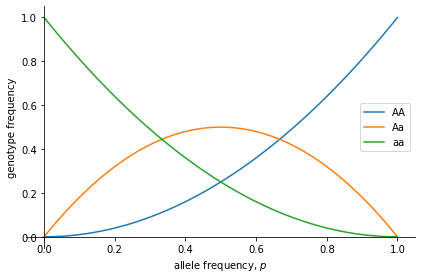

In [1]:
from sympy import *
var('p')
x = p**2 #frequency of AA at Hardy-Weinberg as a function of the frequency of allele A
y = 2*p*(1-p) #freq of Aa
z = (1-p)**2 #freq of aa
p = plot(x, y, z, #functions that we are plotting
     (p,0,1), #plot as a function of allele frequency from 0 to 1
     xlabel="allele frequency, $p$", 
     ylabel="genotype frequency",
     legend=True, show=False
    )
p[0].label='AA' #give legend genotype labels
p[1].label='Aa'
p[2].label='aa'
p.show()

From this plot we see, for example, that the frequency of heterozygotes, Aa, is maximized at intermediate allele frequencies.

Subbing in $p=x+y/2$ and $q=y/2+z$ we get the recursion equations describing the frequency of diploid genotypes in the next generation as a function of the diploid genotypes in the current generation,

$$x' = (x + y/2)^2$$

$$y' = 2(x + y/2)(y/2 + z)$$

$$z' = (y/2 + z)^2$$

#### v. Analyze the equations

Now back to our question. What is the frequency of allele A in the next generation?

$$p' = x' + y'/2$$

$$p' = p^2 + 2pq/2$$

$$p' = p(p + q)$$

$$p' = p$$

#### vi. Checks and balances

- Does $x' + y' + z' = 1$? 

$$
\begin{aligned}
x' + y' + z' 
&= p^2 + 2pq + q^2\\
&= (p+q)^2\\
&= (1)^2\\
&= 1
\end{aligned}
$$

#### vii. Relate the results back to the question

- How do allele frequencies change over time in the absence of natural selection? 
    - They don't

!!! note "Data example: blood types"

    Below is a table describing the frequency of three different blood types (and their associated genotype) in a sample of humans from the USA.

    | Blood type | M | MN | N |
    | ---------- | - | -- | - |
    | Genotype | MM | MN | NN |
    | Observed frequency in USA | 0.292 | 0.496 | 0.212 |

    We ask, are these genotypes near Hardy-Weinberg equilibrium?

    First, write the frequency of each genotype as $x$, $y$ , and $z$
    
    $$x = 0.292$$ 
    
    $$y = 0.496$$ 
    
    $$z = 0.212$$

    Next, convert the genotype frequencies into allele frequencies
    
    $$p = x + y/2 = 0.540$$
    
    $$q = y/2 + z = 0.460$$

    Now predict what the genotype frequencies would be at Hardy-Weinberg equilibrium
    
    $$x = p^2 = 0.2916$$ 
    
    $$y = 2pq = 0.4985$$ 
    
    $$z = q^2 = 0.2116$$

    These predicted genotype frequencies are exceptionally close to those actually observed, indicating Hardy-Weinberg equilibrium and suggesting an absence of selection on this phenotype. 